### Import packages

In [ ]:
# Import required packages
import rasterio
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### Create a PCA and plot the elbow plot
##### This code cell focuses on analysing the explained variance, plotting a graph, and printing how much variance each principal component captures. It is more suited for deciding how many components to retain.

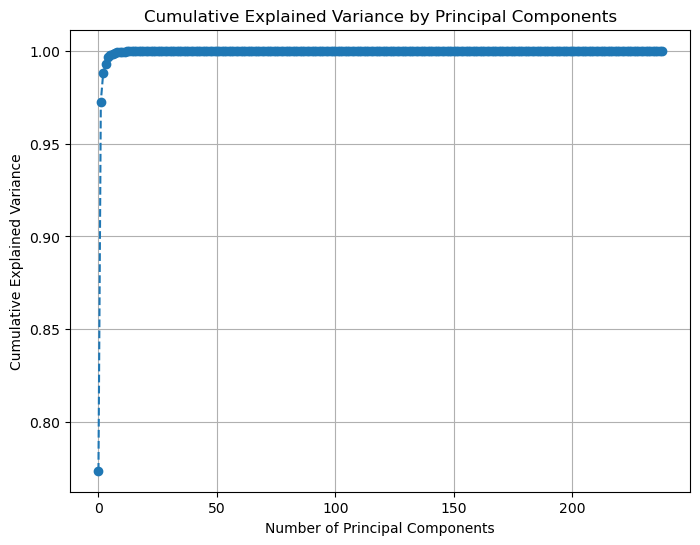

Component 1: 77.39% cumulative variance explained
Component 2: 97.27% cumulative variance explained
Component 3: 98.80% cumulative variance explained
Component 4: 99.27% cumulative variance explained
Component 5: 99.64% cumulative variance explained
Component 6: 99.79% cumulative variance explained
Component 7: 99.85% cumulative variance explained
Component 8: 99.89% cumulative variance explained
Component 9: 99.91% cumulative variance explained
Component 10: 99.94% cumulative variance explained
Component 11: 99.95% cumulative variance explained
Component 12: 99.96% cumulative variance explained
Component 13: 99.96% cumulative variance explained
Component 14: 99.97% cumulative variance explained
Component 15: 99.97% cumulative variance explained
Component 16: 99.98% cumulative variance explained
Component 17: 99.98% cumulative variance explained
Component 18: 99.98% cumulative variance explained
Component 19: 99.98% cumulative variance explained
Component 20: 99.99% cumulative variance

In [1]:
# Create a function
def explained_variance(input_image):
    # Open the image
    with rasterio.open(input_image) as src:
        img = src.read()

        # Reshape the image to (pixels, bands) and convert to float32
        img_reshaped = img.reshape((img.shape[0], -1)).T.astype(np.float32)

        # Check for NaNs or infinite values
        img_reshaped = np.nan_to_num(img_reshaped, nan=0.0, posinf=0.0, neginf=0.0)

        # Scale the data to handle large values
        scaler = StandardScaler()
        img_scaled = scaler.fit_transform(img_reshaped)

    # Perform PCA
    pca = PCA()
    pca.fit(img_scaled)

    # Plot explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Plotting explained variance ratio
    plt.figure(figsize=(8, 6))
    plt.plot(cumulative_variance, marker='o', linestyle='--')
    plt.title('Cumulative Explained Variance by Principal Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

    return cumulative_variance

# Define input path
input_image = r"C:\Users\User\OneDrive - Stellenbosch University\MAPWAPS\DataChapter1\uMzi_ROI\data\EMIT\EMIT_Clipped\EMIT_CLIPPED.tif"

# Compute and plot explained variance
cumulative_variance = explained_variance(input_image)

# Print cumulative variance to choose the number of components
for i, var in enumerate(cumulative_variance):
    print(f"Component {i+1}: {var*100:.2f}% cumulative variance explained")


### Create the PCA and save the resultant image
##### This code cell Focuses on reducing the hyperspectral image and saving the result to a new GeoTIFF file. It is more practical for saving PCA-transformed images rather than analyzing the variance.

In [5]:
# Step 1: Open the original GeoTIFF file
input_tif = r"C:\Users\User\OneDrive - Stellenbosch University\MAPWAPS\DataChapter1\uMzi_ROI\data\EMIT\EMIT_Clipped\EMIT_CLIPPED.tif"
with rasterio.open(input_tif) as src:
    hyperspectral_data = src.read()  # Read all bands into a NumPy array (shape: (n_bands, height, width))
    original_meta = src.meta         # Store metadata for the output file (affine, CRS, etc.)

# Step 2: Reshape the data for PCA (from (n_bands, height, width) to (n_samples, n_bands))
n_bands, height, width = hyperspectral_data.shape
reshaped_data = hyperspectral_data.reshape(n_bands, -1).T  # Shape: (n_samples, n_bands)

# Step 3: Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(reshaped_data)

# Step 4: Apply PCA to retain 99.95% of the variance
pca = PCA(n_components=0.9995, svd_solver='full')
pca_transformed = pca.fit_transform(standardized_data)

# Step 5: Reshape the transformed data back to the original spatial dimensions
n_components = pca_transformed.shape[1]  # Number of components retained
reduced_data = pca_transformed.T.reshape(n_components, height, width)

# Step 6: Update metadata for the new GeoTIFF file
output_meta = original_meta.copy()
output_meta.update({
    "count": n_components,   # Update number of bands to match the reduced number of components
    "dtype": 'float32'       # Ensure the data type is correct for the transformed data
})

# Step 7: Save the reduced data as a new GeoTIFF file
output_tif = r"C:\Users\User\Documents\DataFusion\DataFusion\30092014_PCA\10012024PCA_image.tif"
with rasterio.open(output_tif, 'w', **output_meta) as dst:
    dst.write(reduced_data.astype('float32'))  # Save the reduced bands

print(f"Saved PCA reduced data to {output_tif}")



Saved PCA reduced data to C:\Users\User\Documents\DataFusion\DataFusion\30092014_PCA\10012024PCA_image.tif


### Check the number of components

In [4]:
# Step 3: Check the number of components
print(f"Number of components selected: {pca.n_components_}")
print(f"Explained variance by each component: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.cumsum(pca.explained_variance_ratio_)}")

Number of components selected: 12
Explained variance by each component: [7.73908679e-01 1.98752902e-01 1.53387040e-02 4.68246029e-03
 3.69846754e-03 1.51917340e-03 5.76122385e-04 3.85592945e-04
 2.74375058e-04 2.18730569e-04 1.12647113e-04 9.84638607e-05]
Cumulative explained variance: [0.77390868 0.97266158 0.98800028 0.99268274 0.99638121 0.99790039
 0.99847651 0.9988621  0.99913648 0.99935521 0.99946785 0.99956632]
